In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


## Timing and accuracy results for DG, CG and WPA
<hr style="border-width:4px; border-color:coral"></hr>

In [2]:
import pandas 

In [3]:
idx = pandas.IndexSlice

# Walltime     : time TFinal (global time)
# Integration  : 
# time steps   : Number of time steps to time tfinal
# Prep         : one time step up time
# order        : Order of the scheme (not polynomial order)

ex_list = ['advection','SWE']

cols = ['walltime', 'Prep', 'Integ', 'order','time steps', 'dt', 'cfl','1-norm','2-norm','inf-norm']

iterables = [ex_list, ['DG','CG','WPA'],['exact','inexact','w/lim','wout/lim'], [8,16,32,64,128,256]]

index = pandas.MultiIndex.from_product(iterables,names=['example','method','elements','integration'])
df = pandas.DataFrame(index=index,columns=cols).sort_index()

df

walltime Prep Integ order time steps  \
example   method elements integration                                        
SWE       CG     exact    8                NaN  NaN   NaN   NaN        NaN   
                          16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
...                                        ...  ...   ...   ...        ...   
advection WPA    wout/lim 16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
                          256              NaN  NaN   NaN   NaN        NaN   

                                        dt  cfl 1-norm 2-norm inf-norm  
example   method elements integration                                   
SWE       CG     exact    8            NaN  NaN    NaN    NaN      NaN  
                          16           NaN  NaN    NaN    NaN      NaN  
                          32           NaN  NaN    NaN    NaN      NaN  
                          64           NaN  NaN    NaN    NaN      NaN  
                          128          NaN  NaN    NaN    NaN      NaN  
...                                    ...  ...    ...    ...      ...  
advection WPA    wout/lim 16           NaN  NaN    NaN    NaN      NaN  
                          32           NaN  NaN    NaN    NaN      NaN  
                          64           NaN  NaN    NaN    NaN      NaN  
                          128          NaN  NaN    NaN    NaN      NaN  
                          256          NaN  NaN    NaN    NaN      NaN  

[144 rows x 10 columns]

## Add columns/read in data
<hr style="border-width:4px; border-color:coral"></hr>

In [20]:
# Add a DOF column

# df.loc[idx[:,'DG',:],'DOF'] = (df['order'] + 1)*df['elements']
df.loc[idx[:,'DG',:,:],'DOF'] = 25
df.loc[idx[:,'CG',:,:],'DOF'] = 5
df.loc[idx['advection','WPA','w/lim',:],'DOF'] = df.index.levels[3].values
df.loc[idx['advection',('DG','WPA'),('exact','w/lim'),:],:]

walltime Prep Integ order time steps  \
example   method elements integration                                        
advection DG     exact    8                2.2  NaN   NaN   NaN        NaN   
                          16               4.1  NaN   NaN   NaN        NaN   
                          32               8.2  NaN   NaN   NaN        NaN   
                          64                16  NaN   NaN   NaN        NaN   
                          128               32  NaN   NaN   NaN        NaN   
                          256             67.3  NaN   NaN   NaN        NaN   
                 w/lim    8                NaN  NaN   NaN   NaN        NaN   
                          16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
                          256              NaN  NaN   NaN   NaN        NaN   
          WPA    exact    8                NaN  NaN   NaN   NaN        NaN   
                          16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
                          256              NaN  NaN   NaN   NaN        NaN   
                 w/lim    8                NaN  NaN   NaN   NaN        NaN   
                          16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
                          256              NaN  NaN   NaN   NaN        NaN   

                                        dt  cfl 1-norm 2-norm inf-norm    DOF  
example   method elements integration                                          
advection DG     exact    8            NaN  NaN    NaN    NaN      NaN   25.0  
                          16           NaN  NaN    NaN    NaN      NaN   25.0  
                          32           NaN  NaN    NaN    NaN      NaN   25.0  
                          64           NaN  NaN    NaN    NaN      NaN   25.0  
                          128          NaN  NaN    NaN    NaN      NaN   25.0  
                          256          NaN  NaN    NaN    NaN      NaN   25.0  
                 w/lim    8            NaN  NaN    NaN    NaN      NaN   25.0  
                          16           NaN  NaN    NaN    NaN      NaN   25.0  
                          32           NaN  NaN    NaN    NaN      NaN   25.0  
                          64           NaN  NaN    NaN    NaN      NaN   25.0  
                          128          NaN  NaN    NaN    NaN      NaN   25.0  
                          256          NaN  NaN    NaN    NaN      NaN   25.0  
          WPA    exact    8            NaN  NaN    NaN    NaN      NaN    NaN  
                          16           NaN  NaN    NaN    NaN      NaN    NaN  
                          32           NaN  NaN    NaN    NaN      NaN    NaN  
                          64           NaN  NaN    NaN    NaN      NaN    NaN  
                          128          NaN  NaN    NaN    NaN      NaN    NaN  
                          256          NaN  NaN    NaN    NaN      NaN    NaN  
                 w/lim    8            NaN  NaN    NaN    NaN      NaN    8.0  
                          16           NaN  NaN    NaN    NaN      NaN   16.0  
                          32           NaN  NaN    NaN    NaN      NaN   32.0  
                          64           NaN  NaN    NaN    NaN      NaN   64.0  
                          128          NaN  NaN    NaN    NaN      NaN  128.0  
         

In [5]:
# Set data (read from a file)
df.loc[idx['advection','DG','exact',:],'walltime'] = [2.2, 4.1, 8.2, 16, 32.0, 67.3]
df.loc[idx['advection','CG','exact',:],'walltime'] = [4.2, 6.1, 17.2, 21.2, 64.0, 110.3]
df.loc[idx['advection',('DG','CG'),'exact',:],:]

walltime Prep Integ order time steps  \
example   method elements integration                                        
advection CG     exact    8                4.2  NaN   NaN   NaN        NaN   
                          16               6.1  NaN   NaN   NaN        NaN   
                          32              17.2  NaN   NaN   NaN        NaN   
                          64              21.2  NaN   NaN   NaN        NaN   
                          128               64  NaN   NaN   NaN        NaN   
                          256            110.3  NaN   NaN   NaN        NaN   
          DG     exact    8                2.2  NaN   NaN   NaN        NaN   
                          16               4.1  NaN   NaN   NaN        NaN   
                          32               8.2  NaN   NaN   NaN        NaN   
                          64                16  NaN   NaN   NaN        NaN   
                          128               32  NaN   NaN   NaN        NaN   
                          256             67.3  NaN   NaN   NaN        NaN   

                                        dt  cfl 1-norm 2-norm inf-norm   DOF  
example   method elements integration                                         
advection CG     exact    8            NaN  NaN    NaN    NaN      NaN   5.0  
                          16           NaN  NaN    NaN    NaN      NaN   5.0  
                          32           NaN  NaN    NaN    NaN      NaN   5.0  
                          64           NaN  NaN    NaN    NaN      NaN   5.0  
                          128          NaN  NaN    NaN    NaN      NaN   5.0  
                          256          NaN  NaN    NaN    NaN      NaN   5.0  
          DG     exact    8            NaN  NaN    NaN    NaN      NaN  25.0  
                          16           NaN  NaN    NaN    NaN      NaN  25.0  
                          32           NaN  NaN    NaN    NaN      NaN  25.0  
                          64           NaN  NaN    NaN    NaN      NaN  25.0  
                          128          NaN  NaN    NaN    NaN      NaN  25.0  
                          256          NaN  NaN    NaN    NaN      NaN  25.0

## Using a MultiIndex table

<hr style="border-width:4px; border-color:coral"/>

In [6]:
# Extract all of the data for one example
df.loc['advection']

walltime Prep Integ order time steps   dt  cfl  \
method elements integration                                                  
CG     exact    8                4.2  NaN   NaN   NaN        NaN  NaN  NaN   
                16               6.1  NaN   NaN   NaN        NaN  NaN  NaN   
                32              17.2  NaN   NaN   NaN        NaN  NaN  NaN   
                64              21.2  NaN   NaN   NaN        NaN  NaN  NaN   
                128               64  NaN   NaN   NaN        NaN  NaN  NaN   
...                              ...  ...   ...   ...        ...  ...  ...   
WPA    wout/lim 16               NaN  NaN   NaN   NaN        NaN  NaN  NaN   
                32               NaN  NaN   NaN   NaN        NaN  NaN  NaN   
                64               NaN  NaN   NaN   NaN        NaN  NaN  NaN   
                128              NaN  NaN   NaN   NaN        NaN  NaN  NaN   
                256              NaN  NaN   NaN   NaN        NaN  NaN  NaN   

                            1-norm 2-norm inf-norm  DOF  
method elements integration                              
CG     exact    8              NaN    NaN      NaN  5.0  
                16             NaN    NaN      NaN  5.0  
                32             NaN    NaN      NaN  5.0  
                64             NaN    NaN      NaN  5.0  
                128            NaN    NaN      NaN  5.0  
...                            ...    ...      ...  ...  
WPA    wout/lim 16             NaN    NaN      NaN  NaN  
                32             NaN    NaN      NaN  NaN  
                64             NaN    NaN      NaN  NaN  
                128            NaN    NaN      NaN  NaN  
                256            NaN    NaN      NaN  NaN  

[72 rows x 11 columns]

In [7]:
df.loc[('advection','DG',('exact','inexact')),:]

walltime Prep Integ order time steps  \
example   method elements integration                                        
advection DG     exact    8                2.2  NaN   NaN   NaN        NaN   
                          16               4.1  NaN   NaN   NaN        NaN   
                          32               8.2  NaN   NaN   NaN        NaN   
                          64                16  NaN   NaN   NaN        NaN   
                          128               32  NaN   NaN   NaN        NaN   
                          256             67.3  NaN   NaN   NaN        NaN   
                 inexact  8                NaN  NaN   NaN   NaN        NaN   
                          16               NaN  NaN   NaN   NaN        NaN   
                          32               NaN  NaN   NaN   NaN        NaN   
                          64               NaN  NaN   NaN   NaN        NaN   
                          128              NaN  NaN   NaN   NaN        NaN   
                          256              NaN  NaN   NaN   NaN        NaN   

                                        dt  cfl 1-norm 2-norm inf-norm   DOF  
example   method elements integration                                         
advection DG     exact    8            NaN  NaN    NaN    NaN      NaN  25.0  
                          16           NaN  NaN    NaN    NaN      NaN  25.0  
                          32           NaN  NaN    NaN    NaN      NaN  25.0  
                          64           NaN  NaN    NaN    NaN      NaN  25.0  
                          128          NaN  NaN    NaN    NaN      NaN  25.0  
                          256          NaN  NaN    NaN    NaN      NaN  25.0  
                 inexact  8            NaN  NaN    NaN    NaN      NaN  25.0  
                          16           NaN  NaN    NaN    NaN      NaN  25.0  
                          32           NaN  NaN    NaN    NaN      NaN  25.0  
                          64           NaN  NaN    NaN    NaN      NaN  25.0  
                          128          NaN  NaN    NaN    NaN      NaN  25.0  
                          256          NaN  NaN    NaN    NaN      NaN  25.0

In [8]:
df.loc[('advection','DG',('exact')),['walltime','Prep','1-norm','cfl']]


,walltime,Prep,1-norm,cfl
integration,,,,
8,2.2,NaN,NaN,NaN
16,4.1,NaN,NaN,NaN
32,8.2,NaN,NaN,NaN
64,16,NaN,NaN,NaN
128,32,NaN,NaN,NaN
256,67.3,NaN,NaN,NaN


In [9]:
cols = ['walltime','Prep','time steps','1-norm'] 
df.loc[idx['advection',:,('exact','wout/lim'),:],cols].unstack(1)

walltime            Prep           time steps  \
method                               CG    DG  WPA   CG   DG  WPA         CG   
example   elements integration                                                 
advection exact    8                4.2   2.2  NaN  NaN  NaN  NaN        NaN   
                   16               6.1   4.1  NaN  NaN  NaN  NaN        NaN   
                   32              17.2   8.2  NaN  NaN  NaN  NaN        NaN   
                   64              21.2    16  NaN  NaN  NaN  NaN        NaN   
                   128               64    32  NaN  NaN  NaN  NaN        NaN   
                   256            110.3  67.3  NaN  NaN  NaN  NaN        NaN   
          wout/lim 8                NaN   NaN  NaN  NaN  NaN  NaN        NaN   
                   16               NaN   NaN  NaN  NaN  NaN  NaN        NaN   
                   32               NaN   NaN  NaN  NaN  NaN  NaN        NaN   
                   64               NaN   NaN  NaN  NaN  NaN  NaN        NaN   
                   128              NaN   NaN  NaN  NaN  NaN  NaN        NaN   
                   256              NaN   NaN  NaN  NaN  NaN  NaN        NaN   

                                         1-norm            
method                           DG  WPA     CG   DG  WPA  
example   elements integration                             
advection exact    8            NaN  NaN    NaN  NaN  NaN  
                   16           NaN  NaN    NaN  NaN  NaN  
                   32           NaN  NaN    NaN  NaN  NaN  
                   64           NaN  NaN    NaN  NaN  NaN  
                   128          NaN  NaN    NaN  NaN  NaN  
                   256          NaN  NaN    NaN  NaN  NaN  
          wout/lim 8            NaN  NaN    NaN  NaN  NaN  
                   16           NaN  NaN    NaN  NaN  NaN  
                   32           NaN  NaN    NaN  NaN  NaN  
                   64           NaN  NaN    NaN  NaN  NaN  
                   128          NaN  NaN    NaN  NaN  NaN  
                   256          NaN  NaN    NaN  NaN  NaN

In [16]:
df.loc[idx['advection',('DG','CG'),'exact'],:].\
       style.background_gradient(subset=['walltime'],cmap='YlOrBr')

## Plotting : CG vs. DG
<hr style="border-width:4px; border-color:coral"></hr>

In [22]:
# set up nice tick marks for log data
def set_xticks(P):
    p0 = log2(P[0])
    p1 = log2(P[-1])
    xlim([2**(p0-1), 2**(p1+1)])
    
    Pstr = (['{:d}'.format(int(p)) for p in P])
    xticks(P,Pstr)

<IPython.core.display.Javascript object>


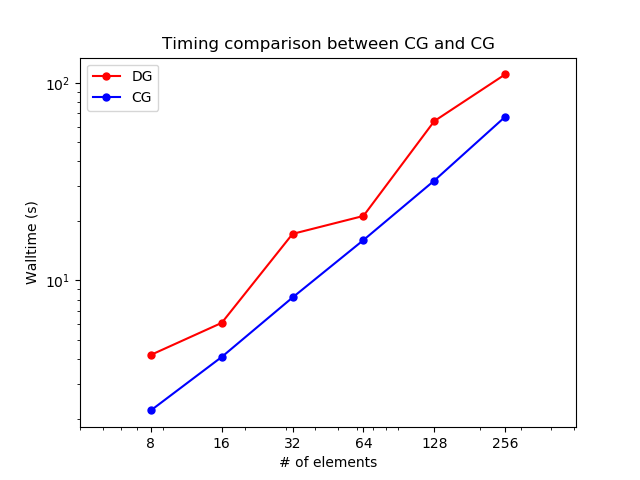

In [25]:
figure(1)
clf()

# Retrieve element values - level 3 in the Multiindex
Nv = df.index.levels[3].values

# Retrieve time values 
time_dg = df.loc[idx['advection','DG','exact',:],'walltime'].values
time_cg = df.loc[idx['advection','CG','exact',:],'walltime'].values

loglog(Nv,time_cg,'r.-',markersize=10,label='DG')
loglog(Nv,time_dg,'b.-',markersize=10,label='CG')

set_xticks(Nv)

title('Timing comparison between CG and CG')
xlabel('# of elements')
ylabel('Walltime (s)')

legend()